# Predictive task description

Here are the steps:

    1. Prepare predictive model(s) of default. Default client is defined as one with loan_status variable taking on the following levels:
    Charged Off
    Default
    Does not meet the credit policy. Status:Charged Off
    Late (31-120 days)

    2. Present a few competing predictive models and select one of them. Explain criteria for the selection.

    3. Calculate performance metrics you find important in this specific context, but also provide necessarily ROC graphs and AUC for comparison purposes. Metrics should be based on testing set, which should consist 30% randomly selected clients from the original dataset.

    4. If necessary, make appropriate variables' pre-processing.

    5. Send us a programming code with comments and the report/presentation of main results.

We hope you will enjoy solving the task! Good luck!

# Models

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

    I will use files prepared with PreProcessing.ipynb

In [3]:
# file pahts
processed_data_path = os.path.join(os.path.pardir,'data','processed')
X_path = os.path.join(processed_data_path, 'X.csv')
y_path = os.path.join(processed_data_path, 'y.csv')
X_train_path = os.path.join(processed_data_path, 'X_train.csv')
y_train_path = os.path.join(processed_data_path, 'y_train.csv')
X_test_path = os.path.join(processed_data_path, 'X_test.csv')
y_test_path = os.path.join(processed_data_path, 'y_test.csv')

figures_data_path = os.path.join(os.path.pardir, 'reports', 'figures')

the whole sample

In [4]:
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path,header=None,names=['Default'])
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path,header=None,names=['Default'])

small sample (5%)

In [5]:
# file pahts
processed_data_path = os.path.join(os.path.pardir,'data','processed')
X_small_path = os.path.join(processed_data_path, 'X_small.csv')
y_small_path = os.path.join(processed_data_path, 'y_small.csv')
X_train_small_path = os.path.join(processed_data_path, 'X_train_small.csv')
y_train_small_path = os.path.join(processed_data_path, 'y_train_small.csv')
X_test_small_path = os.path.join(processed_data_path, 'X_test_small.csv')
y_test_small_path = os.path.join(processed_data_path, 'y_test_small.csv')

In [6]:
X_train = pd.read_csv(X_train_small_path)
y_train = pd.read_csv(y_train_small_path,header=None,names=['Default'])
X_test = pd.read_csv(X_test_small_path)
y_test = pd.read_csv(y_test_small_path,header=None,names=['Default'])

# ==================================

# functions

In [7]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [8]:
# file pahts
model_data_path = os.path.join(os.path.pardir,'models')

In [9]:
import pickle
def modelpersistence(alg, filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'wb')
    pickle.dump(alg, model_file_pickle)
    model_file_pickle.close()

In [10]:
def modelload(filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'r')
    alg_loaded = pickle.load(model_file_pickle)
    model_file_pickle.close()
    return alg_loaded

In [11]:
# file pahts
submission_data_path = os.path.join(os.path.pardir,'data','external')

In [12]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # fit file path
    filename_path = os.path.join(submission_data_path, filename)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict probabilities for class 1 in training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predictions = alg.predict_proba(dtrain[predictors])[:, 1]
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=kfold, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("AUC ROC train: %.4g" % metrics.roc_auc_score(dtrain[target].values, dtrain_predictions))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    modelpersistence(alg, filename)
    
    #Predict probabilities for class 1 in testing data:
    #dtest[target] = alg.predict(dtest[predictors])
    dtest[target] = alg.predict_proba(dtest[predictors])[:, 1]
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename_path, index=False)
    #return np.mean(cv_score), metrics.mean_squared_error(dtrain[target].values, dtrain_predictions

In [13]:
def testprediction(filename):
    # fit filt path
    filename_path = os.path.join(submission_data_path, filename)
    
    test_predictions = pd.read_csv(filename_path)
    roc_auc_score = metrics.roc_auc_score(y_test[target], test_predictions[target])
    
    curvelab = 'AUC=' + str(round(roc_auc_score,5))

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test[target], test_predictions[target])

    plt.plot(fpr, tpr, label = curvelab)
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for '+ target + ' classifier on test')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(figures_data_path, filename + '.png'), bbox_inches='tight')
    plt.show()
    #return roc_auc_score

In [36]:
def modeltest(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # fit filt path
    filename_path = os.path.join(submission_data_path, filename)
    
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict_proba(dtrain[predictors])[:, 1]
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=kfold, scoring='roc_auc')
    return np.mean(cv_score), metrics.roc_auc_score(dtrain[target].values, dtrain_predictions)

In [15]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [16]:
#train = pd.merge(X_train, pd.DataFrame(y_train), left_index=True, right_index=True)
#test = pd.merge(X_test, pd.DataFrame(y_test), left_index=True, right_index=True)

In [17]:
test

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_year,issue_month,state_pct_default,time_pct_paid,cr_line_days,pull_minus_last_pymnt,Default
0,187567,8000.0,8000.0,1525.000000,36,14.70,276.15,5,55,0,1,52800.00,0,3,18.52,0.0,2.0,13.0,0.0,20383.0,67.90,27.0,0,0.00,0.00,9940.410000,1894.31,8000.00,1940.41,0.00,0.00,0.0000,280.91,0.0,0.0,0.0,17000.0,2007,12,0.049180,1.028519,3713,1826,0
1,54878256,7800.0,7800.0,7800.000000,36,9.17,248.66,2,22,8,1,44000.00,0,3,25.04,0.0,0.0,17.0,0.0,11274.0,35.10,35.0,1,6643.78,6643.78,1484.010000,1484.01,1156.22,327.79,0.00,0.00,0.0000,248.66,0.0,0.0,31082.0,32100.0,2015,7,0.087102,0.167922,4809,0,0
2,1190570,28000.0,28000.0,28000.000000,36,7.62,872.52,1,13,10,3,78000.00,1,5,24.32,0.0,2.0,7.0,0.0,19422.0,37.10,24.0,0,0.00,0.00,29549.780000,29549.78,28000.00,1549.78,0.00,0.00,0.0000,20701.98,0.0,0.0,0.0,17000.0,2012,3,0.064033,0.279261,6968,31,0
3,53884338,4925.0,4925.0,4925.000000,36,17.86,177.71,4,45,7,1,35000.00,0,5,12.11,0.0,3.0,11.0,1.0,619.0,4.20,20.0,0,4274.77,4274.77,1056.490000,1056.49,650.23,406.26,0.00,0.00,0.0000,177.71,0.0,0.0,6932.0,14900.0,2015,7,0.056713,0.167922,3682,0,0
4,7924984,9125.0,9125.0,9075.000000,36,8.60,288.48,1,14,7,2,75000.00,2,3,14.40,1.0,0.0,9.0,0.0,13094.0,88.50,36.0,0,2774.37,2759.17,7500.200000,7459.10,6350.63,1149.57,0.00,0.00,0.0000,288.48,0.0,0.0,680620.0,14800.0,2013,10,0.085921,0.721880,9711,31,0
5,65914958,20000.0,20000.0,20000.000000,36,13.18,675.62,3,33,2,2,68400.00,2,3,14.47,0.0,0.0,17.0,0.0,24764.0,91.70,30.0,1,19544.05,19544.05,763.490000,763.49,455.95,307.54,0.00,0.00,0.0000,778.13,0.0,0.0,153681.0,27000.0,2015,12,0.075949,0.028291,5661,0,0
6,3149464,9600.0,9600.0,9600.000000,36,18.49,349.43,4,42,3,1,39200.00,0,3,18.09,0.0,0.0,16.0,0.0,13764.0,86.00,29.0,1,0.00,0.00,10933.580000,10933.58,9600.00,1333.58,0.00,0.00,0.0000,7788.71,0.0,0.0,27843.0,16000.0,2013,1,0.066838,0.277436,4263,120,0
7,18605650,10000.0,10000.0,10000.000000,60,14.49,235.24,3,34,10,3,190000.00,1,5,9.62,0.0,0.0,4.0,0.0,193537.0,0.00,21.0,1,7571.30,7571.30,4469.560000,4469.56,2428.70,2040.86,0.00,0.00,0.0000,235.24,0.0,0.0,377146.0,200000.0,2014,6,0.074369,0.317043,6635,0,0
8,32018969,14400.0,14400.0,14400.000000,60,10.99,313.02,2,23,5,2,85000.00,1,3,5.83,2.0,0.0,11.0,0.0,14242.0,46.40,19.0,1,11707.40,11707.40,4373.490000,4373.49,2692.60,1680.89,0.00,0.00,0.0000,313.02,0.0,0.0,431024.0,30700.0,2014,10,0.085921,0.233265,8401,31,0
9,62147452,5000.0,5000.0,4975.000000,36,17.57,179.69,4,44,10,1,45000.00,2,3,19.20,0.0,1.0,7.0,0.0,16772.0,84.30,9.0,0,4785.48,4761.55,354.500000,352.73,214.52,139.98,0.00,0.00,0.0000,179.69,0.0,0.0,25146.0,19900.0,2015,10,0.085921,0.083961,11079,0,0


    Some variables give very accurate information about Default. 

In [18]:
IDcol = ['id']
target = 'Default'
my_features = ['issue_year','issue_month', 'state_pct_default', 'time_pct_paid', 'cr_line_days','pull_minus_last_pymnt']
leakage = ['total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'total_rec_prncp','last_pymnt_amnt']
predictors = [x for x in train.columns if x not in [target]+IDcol+leakage+my_features]
#predictors = [x for x in train.columns if x not in [target]+IDcol+leakage]
#predictors = [x for x in train.columns if x not in [target]+IDcol]

# ==================================

# baseline

In [19]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
# y_test.mean()

# ==================================

# Logistic Regression


Model Report
AUC ROC train: 0.8011
CV Score : Mean - 0.7968 | Std - 0.01149 | Min - 0.7745 | Max - 0.8083


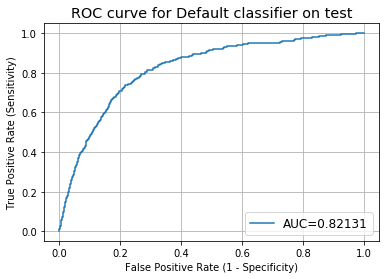

In [20]:
from sklearn.linear_model import LogisticRegression
alg10 = LogisticRegression(class_weight={0: 0.066, 1: 0.934})
modelfit(alg10, train, test, predictors, target, IDcol, 'alg10.csv')
testprediction('alg10.csv')

    because data is unbalanced I will use parameter: class_weight='balanced'


Model Report
AUC ROC train: 0.7966
CV Score : Mean - 0.7956 | Std - 0.01321 | Min - 0.7694 | Max - 0.8108


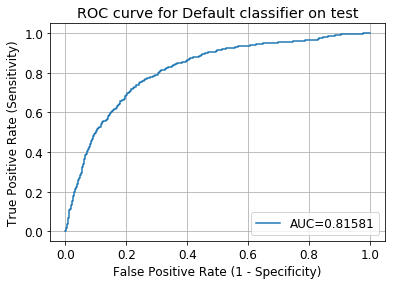

In [21]:
from sklearn.linear_model import LogisticRegression
alg11 = LogisticRegression(class_weight='balanced')
modelfit(alg11, train, test, predictors, target, IDcol, 'alg11.csv')
testprediction('alg11.csv')

# Logistic Regression Scaled MinMaxScaler

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [23]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8038
CV Score : Mean - 0.8004 | Std - 0.01352 | Min - 0.766 | Max - 0.8149


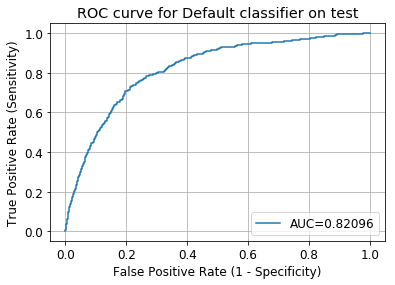

In [24]:
from sklearn.linear_model import LogisticRegression
alg12 = LogisticRegression(class_weight='balanced')
modelfit(alg12, train, test, predictors, target, IDcol, 'alg12.csv')
testprediction('alg12.csv')

# Logistic Regression Scaled StandardScaler

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [26]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8046
CV Score : Mean - 0.8002 | Std - 0.01293 | Min - 0.7694 | Max - 0.8147


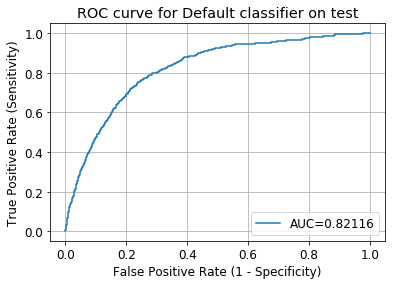

In [27]:
from sklearn.linear_model import LogisticRegression
alg13 = LogisticRegression(class_weight='balanced')
modelfit(alg13, train, test, predictors, target, IDcol, 'alg13.csv')
testprediction('alg13.csv')

# Logistic Regression Scaled RobustScaler

In [28]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [29]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8046
CV Score : Mean - 0.8003 | Std - 0.01296 | Min - 0.7692 | Max - 0.8147


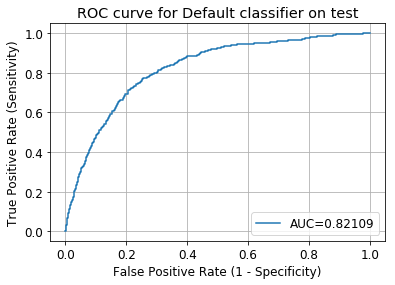

In [30]:
from sklearn.linear_model import LogisticRegression
alg14 = LogisticRegression(class_weight='balanced')
modelfit(alg14, train, test, predictors, target, IDcol, 'alg14.csv')
testprediction('alg14.csv')

# ==================================

# Decisions Trees

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [38]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8424
CV Score : Mean - 0.8081 | Std - 0.008332 | Min - 0.7932 | Max - 0.8197


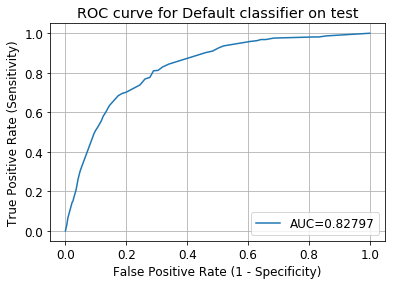

In [39]:
from sklearn.tree import DecisionTreeClassifier
alg20 = DecisionTreeClassifier(
    max_depth = 6,
    criterion='entropy',
    class_weight='balanced',
    min_weight_fraction_leaf=0.01,
    random_state=42)
modelfit(alg20, train, test, predictors, target, IDcol, 'alg20.csv')
testprediction('alg20.csv')

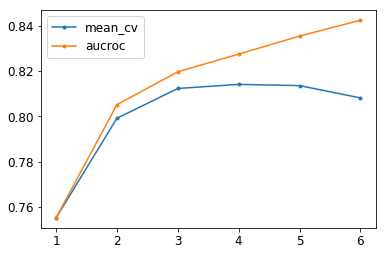

In [40]:
points=[]
for i in range(1,7):
    alg_name='alg20_%d'%i
    file_name = 'alg20_%d'%i
    alg_name = DecisionTreeClassifier(
                                    max_depth = i,
                                    criterion='entropy',
                                    class_weight='balanced',
                                    min_weight_fraction_leaf=0.01,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [41]:
points.to_csv('alg20_max_depth.csv',index=False)

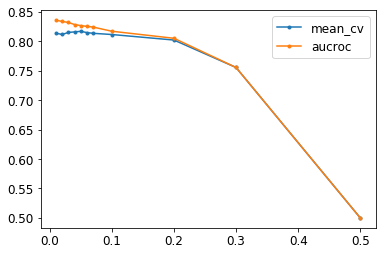

In [42]:
points=[]
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.2,0.3,0.5]:
    alg_name='alg20_%d'%i
    file_name = 'alg20_%d'%i
    alg_name = DecisionTreeClassifier(
                                    max_depth = 5,
                                    criterion='entropy',
                                    class_weight='balanced',
                                    min_weight_fraction_leaf=i,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [43]:
points.to_csv('alg20_min_weight_fraction_leaf.csv',index=False)


Model Report
AUC ROC train: 0.8354
CV Score : Mean - 0.8135 | Std - 0.009658 | Min - 0.7978 | Max - 0.8313


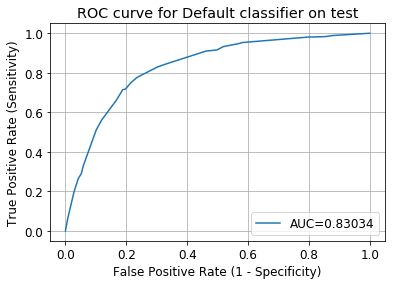

In [44]:
from sklearn.tree import DecisionTreeClassifier
alg21 = DecisionTreeClassifier(
    max_depth = 5,
    criterion='entropy',
    class_weight='balanced',
    min_weight_fraction_leaf=0.01,
    random_state=42)
modelfit(alg21, train, test, predictors, target, IDcol, 'alg21.csv')
testprediction('alg21.csv')

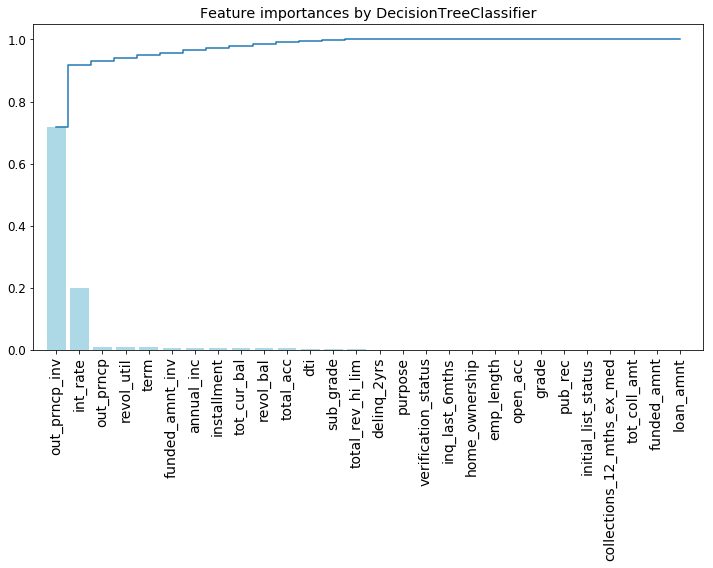

In [45]:
importances = alg21.feature_importances_
feat_names = train[predictors].columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Random Forest Classifier


Model Report
AUC ROC train: 0.865
CV Score : Mean - 0.8224 | Std - 0.01126 | Min - 0.7981 | Max - 0.8401


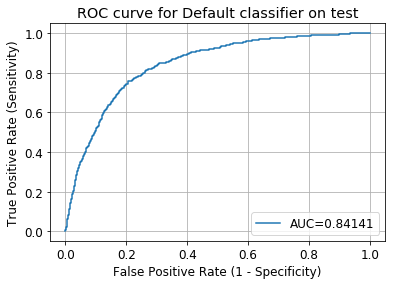

In [46]:
from sklearn.ensemble import RandomForestClassifier

alg30 = RandomForestClassifier(
    max_depth = 6,
    #min_samples_split=30, 
    n_estimators= 100,
    class_weight='balanced',
    random_state=42)
modelfit(alg30, train, test, predictors, target, IDcol, 'alg30.csv')
testprediction('alg30.csv')

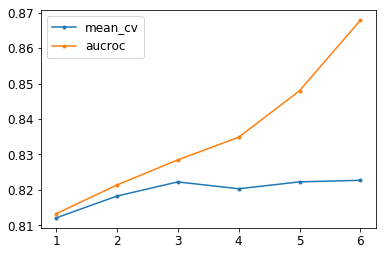

In [47]:
points=[]
for i in range(1,7):
    alg_name='alg30_%d'%i
    file_name = 'alg30_%d'%i
    alg_name = RandomForestClassifier(
                                    n_estimators=50,
                                    max_depth=i,
                                    #min_samples_split=15,
                                    n_jobs=-1,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [48]:
points.to_csv('alg30_max_depth.csv',index=False)

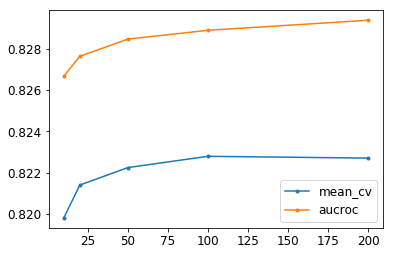

In [49]:
points=[]
for i in [10,20,50,100,200]:
    alg_name='alg30_%d'%i
    file_name = 'alg30_%d'%i
    alg_name = RandomForestClassifier(
                                    n_estimators=i,
                                    max_depth=3,
                                    #min_samples_split=15,
                                    n_jobs=-1,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [50]:
points.to_csv('alg30_n_estimators.csv',index=False)


Model Report
AUC ROC train: 0.8296
CV Score : Mean - 0.8225 | Std - 0.01023 | Min - 0.7995 | Max - 0.8359


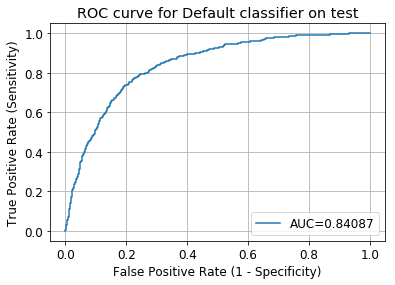

In [51]:
alg31 = RandomForestClassifier(
    max_depth = 3,
    #min_samples_split=30, 
    n_estimators= 100,
    class_weight='balanced',
    random_state=42)
modelfit(alg31, train, test, predictors, target, IDcol, 'alg31.csv')
testprediction('alg31.csv')

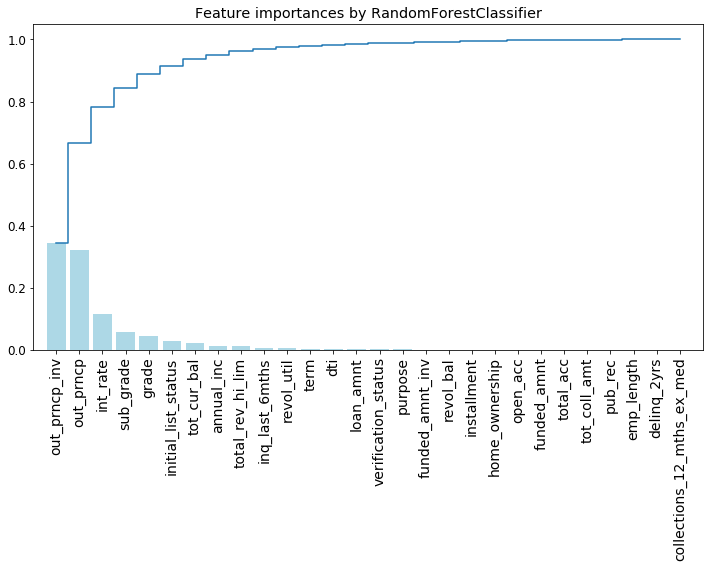

In [52]:
importances = alg31.feature_importances_
feat_names = train[predictors].columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForestClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Gradient Boosting Classifier


Model Report
AUC ROC train: 0.8799
CV Score : Mean - 0.7563 | Std - 0.03041 | Min - 0.693 | Max - 0.7948


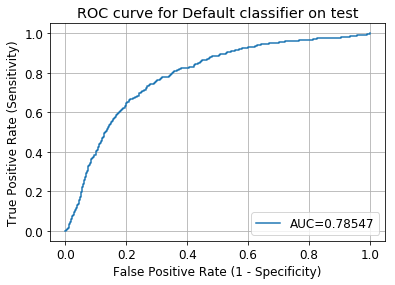

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
alg40 = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    #class_weight='balanced', 
    learning_rate=1.0, 
    random_state=42)
modelfit(alg40, train, test, predictors, target, IDcol, 'alg40.csv')
testprediction('alg40.csv')

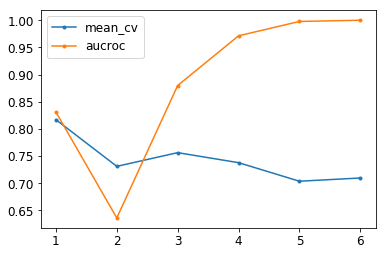

In [54]:
points=[]
for i in range(1,7):
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=100, 
                                    max_depth=i,
                                    #class_weight='balanced', 
                                    learning_rate=1.0, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [55]:
points.to_csv('alg40_max_depth.csv',index=False)

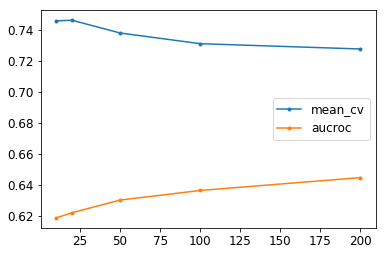

In [56]:
points=[]
for i in [10,20,50,100,200]:
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=i, 
                                    max_depth=2,
                                    #class_weight='balanced', 
                                    learning_rate=1.0, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [57]:
points.to_csv('alg40_n_estimators.csv',index=False)

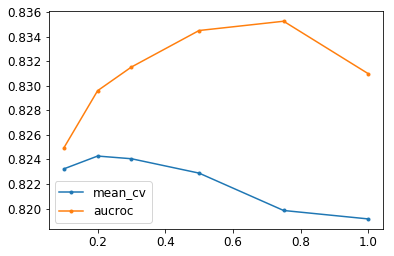

In [58]:
points=[]
for i in [0.1,0.2,0.3,0.5,0.75,1]:
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=50, 
                                    max_depth=1,
                                    #class_weight='balanced', 
                                    learning_rate=i, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [59]:
points.to_csv('alg40_learning_rate.csv',index=False)


Model Report
AUC ROC train: 0.9035
CV Score : Mean - 0.7963 | Std - 0.01331 | Min - 0.7655 | Max - 0.8185


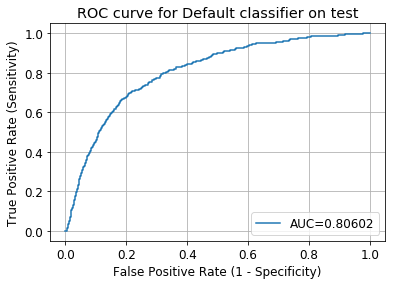

In [60]:
alg41 = GradientBoostingClassifier(
    n_estimators=200, 
    max_depth=2,
    #class_weight='balanced', 
    learning_rate=0.5, 
    random_state=42)
modelfit(alg41, train, test, predictors, target, IDcol, 'alg41.csv')
testprediction('alg41.csv')

# ============================================

    This is how I looked for suspicious features

In [ ]:
def modelfitIncrement(alg, dtrain, dtest, predictors, target):
    for i in range(20,len(predictors)):
        partpredictors = predictors[0:i]
        alg.fit(dtrain[partpredictors], dtrain[target])
        dtrain_predictions = alg.predict_proba(dtrain[partpredictors])[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(dtrain[target], dtrain_predictions)
        roc_auc_score = metrics.roc_auc_score(dtrain[target].values, dtrain_predictions)
        curvelab = '#'+str(i+1)+'Feat_'+predictors[i]+str(round(roc_auc_score,4))
        plt.plot(fpr, tpr, label = curvelab)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for '+ target + ' classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(bbox_to_anchor=(1.04,0), loc='lower left')
    plt.grid(True)
    plt.show()

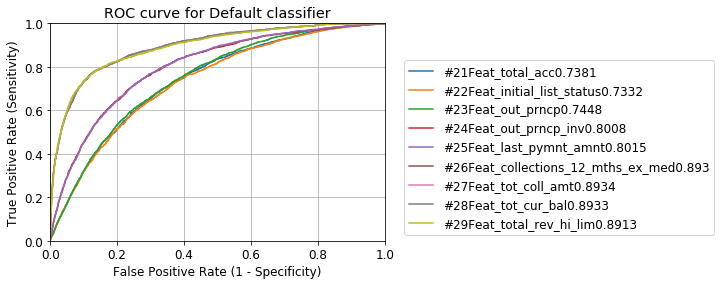

In [66]:
from sklearn.linear_model import LogisticRegression
algS3 = LogisticRegression(class_weight='balanced')
modelfitIncrement(algS3, train, test, predictors, target)

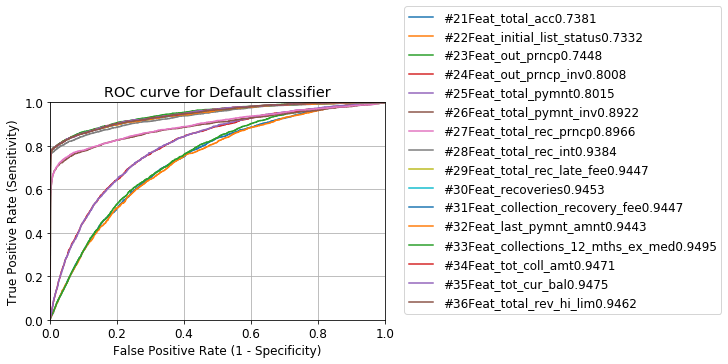

In [40]:
plt.legend(bbox_to_anchor=(1.04,0), loc='lower left')
plt.grid(True)
plt.show()

# ====================================